In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline

sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(13, 6)}
        )

## Задача: 
Имеется крупное дейтинговое приложение.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.\
Требуется:
- проверить был ли эксперимент успешен в целом
- и проанализировать, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

## Был ли эксперимент успешен в целом?

Загружаем данные.

In [2]:
# Информация о пользователях в тестовой группе.
users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', sep=';')
# Информация о платежях пользователей в тесовой группе.
transactions_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
# Информация о пользователях в первой контрольной группе.
users_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', sep=';')
# Информация о платежях пользователей в первой контрольной группе.
transactions_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
# Информация о пользователях во второй контрольной группе.
users_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', sep=';')
# Информация о платежях пользователей во второй контрольной группе.
transactions_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
# Удаляем пустые строки в таблице с данными о платежах в первой контрольной группе.
transactions_control_1.dropna(inplace=True)

### 1. Анализ поведения пользователей, конверсия, повторные подписки.

1.1 Сравние числа пользователей в тестовой и конрольных группах.

In [3]:
test_unique = users_test.uid.nunique()
control_1_unique = users_control_1.uid.nunique()
control_2_unique = users_control_2.uid.nunique()
print(f'В тестовой группе\t\t {test_unique} пользователей.')
print(f'В первой контрольной группе\t {control_1_unique} пользователей.')
print(f'Во второй контрольной группе\t {control_2_unique} пользователей.')

В тестовой группе		 4308 пользователей.
В первой контрольной группе	 4340 пользователей.
Во второй контрольной группе	 4264 пользователей.


Как видим, в тестовой группе на 32 пользователя меньше, чем в первой контрольной группе, и на 44 пользователя больше, чем во второй тестовой группе.

1.2 Сколько из них совершившили покупку.

In [4]:
test_customer = transactions_test.uid.nunique()
control_1_customer = transactions_control_1.uid.nunique()
control_2_customer = transactions_control_2.uid.nunique()
print(f'В тестовой группе\t\t {test_customer} покупателей.')
print(f'В первой контрольной группе\t {control_1_customer} покупателей.')
print(f'Во второй контрольной группе\t {control_2_customer} покупателей.')

В тестовой группе		 146 покупателей.
В первой контрольной группе	 193 покупателей.
Во второй контрольной группе	 187 покупателей.


В первой контрольной группе на 47 (на 32%) покупателей больше, чем в  тестовой группе, а во второй контрольной группе на 41 (на 28%) покупателя больше, чем в тестовой группе.

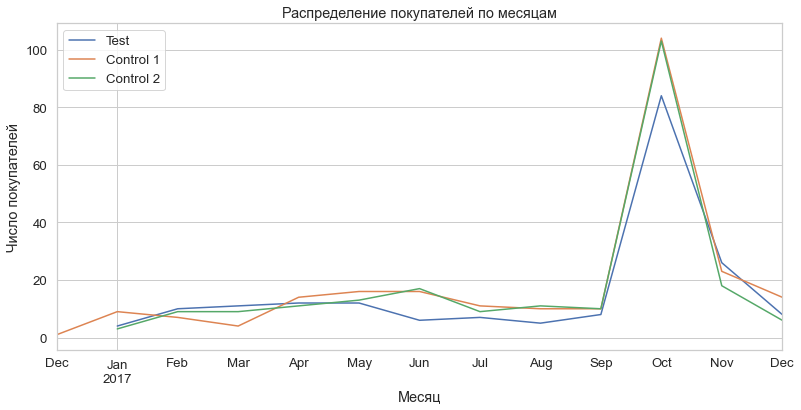

In [5]:
#  Распределение покупателей по месяцам.
transactions_test.set_index('paid_at').resample('m').uid.nunique().plot()
transactions_control_1.set_index('paid_at').resample('m').uid.nunique().plot()
transactions_control_2.set_index('paid_at').resample('m').uid.nunique().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение покупателей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число покупателей');

In [6]:
# Представим данные о количестиве покупателей с разбивкой по месяцам в виде таблицы.
customers_by_month_test = transactions_test.set_index('paid_at').resample('m').uid.nunique().reset_index()
customers_by_month_control_1 = transactions_control_1.set_index('paid_at').resample('m').uid.nunique().reset_index()
customers_by_month_control_2 = transactions_control_2.set_index('paid_at').resample('m').uid.nunique().reset_index()
customers_by_month = (
    customers_by_month_test
    .merge(customers_by_month_control_1, on='paid_at')
    .merge(customers_by_month_control_2, on='paid_at')
    .rename(columns={'uid_x': 'Test', 'uid_y': 'Control_1', 'uid': 'Control_2'})
    )
customers_by_month

,paid_at,Test,Control_1,Control_2
0,2017-01-31,4,9,3
1,2017-02-28,10,7,9
2,2017-03-31,11,4,9
3,2017-04-30,12,14,11
4,2017-05-31,12,16,13
5,2017-06-30,6,16,17
6,2017-07-31,7,11,9
7,2017-08-31,5,10,11
8,2017-09-30,8,10,10
9,2017-10-31,84,104,103


Как можно заметить, в течении всего года число пользователей, совершивших покупку,  во всех группах не превышало 20 человек, за исключением октября и ноября. Но даже в октябре, когда численность покупателей в конрольных группах превысила 100 человек (104 и 103 соотвественно в первой и второй контрольной групах), в тестовой она составляла 84 человека.

Надо заметить, что число общее число покупателей и сумма покупателей по месяцам не совпадает, так как некоторое пользователи совершали покупки в разные месяцы.

1.3 Количество премиум-подписок.

In [181]:
test_premium = transactions_test[transactions_test.product_type=='premium_no_trial'].uid.count()
control_1_premium = transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].uid.count()
control_2_premium = transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].uid.count()
print(f'В тестовой группе\t\t {test_premium} премиум-подписок.')
print(f'В первой контрольной группе\t {control_1_premium} премиум-подписок.')
print(f'Во второй контрольной группе\t {control_2_premium} премиум-подписок.')

В тестовой группе		 76 премиум-подписок.
В первой контрольной группе	 106 премиум-подписок.
Во второй контрольной группе	 107 премиум-подписок.


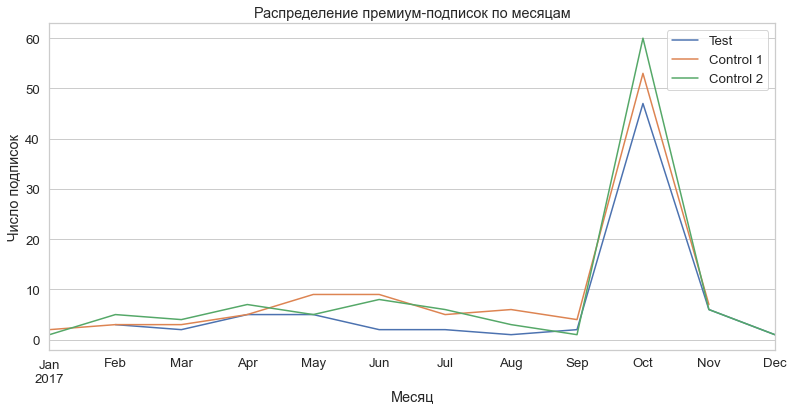

In [182]:
# Распределение премиум-подписок по месяцам.
transactions_test[transactions_test.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().plot()
transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().plot()
transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение премиум-подписок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число подписок');

In [183]:
# Представим данные о количестиве премиум-подписок с разбивкой по месяцам в виде таблицы.
premium_by_month_test = transactions_test[transactions_test.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().reset_index()
premium_by_month_control_1 = transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().reset_index()
premium_by_month_control_2 = transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].set_index('paid_at').resample('m').uid.count().reset_index()
premium_by_month = (
    premium_by_month_test
    .merge(premium_by_month_control_1, on='paid_at')
    .merge(premium_by_month_control_2, on='paid_at')
    .rename(columns={'uid_x': 'Test', 'uid_y': 'Control_1', 'uid': 'Control_2'})
    )
premium_by_month

,paid_at,Test,Control_1,Control_2
0,2017-02-28,3,3,5
1,2017-03-31,2,3,4
2,2017-04-30,5,5,7
3,2017-05-31,5,9,5
4,2017-06-30,2,9,8
5,2017-07-31,2,5,6
6,2017-08-31,1,6,3
7,2017-09-30,2,4,1
8,2017-10-31,47,53,60
9,2017-11-30,6,7,6


Количество премиум-подписок в тествой группе меньше, чем в первой контрольной группе на 30 (т. е. на 39%), и на 31 (т. е. на 41%), чем во второй.
Также можно заметить, что, в подавляющем большинстве случаев, количество премиум подписок в тествой группе на протяжении вмего года была ниже, чем в контрольных группах, даже в октябре, когда число подписок резко возрасло (53 и 60 соответсвенно в первой и второй контрольных группах), в тестовой группе их число составляло только 47.

1.4 Количество пробных премиум-подписок

In [184]:
test_trial = transactions_test[transactions_test.product_type=='trial_premium'].uid.count()
control_1_trial = transactions_control_1[transactions_control_1.product_type=='trial_premium'].uid.count()
control_2_trial = transactions_control_2[transactions_control_2.product_type=='trial_premium'].uid.count()
print(f'В тестовой группе\t\t {test_trial} пробных премиум-подписок.')
print(f'В первой контрольной группе\t {control_1_trial} пробных премиум-подписок.')
print(f'Во второй контрольной группе\t {control_2_trial} пробных премиум-подписок.')

В тестовой группе		 62 пробных премиум-подписок.
В первой контрольной группе	 67 пробных премиум-подписок.
Во второй контрольной группе	 53 пробных премиум-подписок.


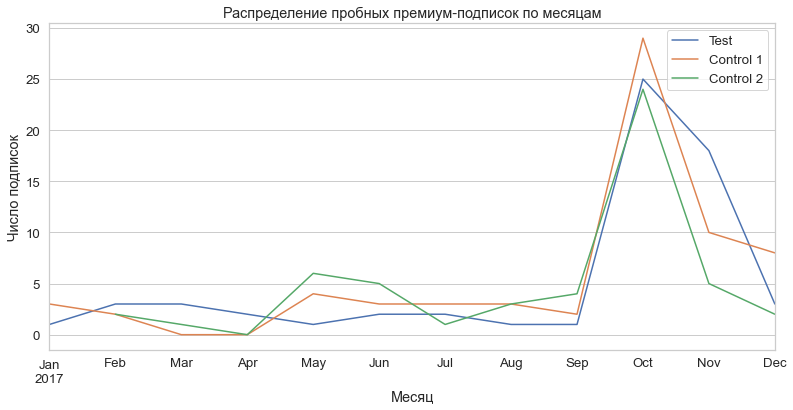

In [185]:
# Распределение по месяцам
transactions_test[transactions_test.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().plot()
transactions_control_1[transactions_control_1.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().plot()
transactions_control_2[transactions_control_2.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение пробных премиум-подписок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число подписок');

In [186]:
# Представим данные о количестиве пробных премиум-подписок с разбивкой по месяцам в виде таблицы.
trial_by_month_test = transactions_test[transactions_test.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().reset_index()
trial_by_month_control_1 = transactions_control_1[transactions_control_1.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().reset_index()
trial_by_month_control_2 = transactions_control_2[transactions_control_2.product_type=='trial_premium'].set_index('paid_at').resample('m').uid.count().reset_index()
trial_by_month = (
    trial_by_month_test
    .merge(trial_by_month_control_1, on='paid_at')
    .merge(trial_by_month_control_2, on='paid_at')
    .rename(columns={'uid_x': 'Test', 'uid_y': 'Control_1', 'uid': 'Control_2'})
    )
trial_by_month

,paid_at,Test,Control_1,Control_2
0,2017-02-28,3,2,2
1,2017-03-31,3,0,1
2,2017-04-30,2,0,0
3,2017-05-31,1,4,6
4,2017-06-30,2,3,5
5,2017-07-31,2,3,1
6,2017-08-31,1,3,3
7,2017-09-30,1,2,4
8,2017-10-31,25,29,24
9,2017-11-30,18,10,5


За весь период количество пробных премиум-подписок, цена на которые в тестовой группе не изменялась, в тестовой группе на 5 (8%) меньше, чем в первой контрольной группе, но на 9 (14,5%) больше, чем во второй контрольной группе. Распределение пробных премиум-подписок довольно сильно отличается в разных группах по месяцам. Стоит отметить, что после значительного подъема числа продных подписок в октябре месяце во всех группах (25 в тестовой, 29 в первой контрольной и 24 во второй контрольной), в тестовой и первой контрольной группе в следующем месяце (ноябре) число подписок оставалось на довольно высоком уровне (18 в тестовой и 10 в первой контрльной), но в тестовой группе в декабре месяце число пробных подписок снизилось до 3, в то время как, в первой контрольной их было 8.

1.5 Конверсия в покупателя.

In [187]:
test_conversion = test_customer/test_unique
control_1_conversion = control_1_customer/control_1_unique
control_2_conversion = control_2_customer/control_2_unique
print(f'В тестовой группе покупки совершили\t\t {test_conversion:.2%} пользователей.')
print(f'В первой контрольной группе покупки совершили\t {control_1_conversion:.2%} пользователей.')
print(f'Во второй контрольной группе покупки совершили\t {control_2_conversion:.2%} пользователей.')

В тестовой группе покупки совершили		 3.39% пользователей.
В первой контрольной группе покупки совершили	 4.45% пользователей.
Во второй контрольной группе покупки совершили	 4.39% пользователей.


1.6 Конверсия в премиум-подписку.

In [188]:
test_premium_conversion = test_premium/test_customer
control_1_premium_conversion = control_1_premium/control_1_customer
control_2_premium_conversion = control_2_premium/control_2_customer
print(f'В тестовой группе премиум-подписку приобрели\t\t {test_premium_conversion:.2%} покупателей.')
print(f'В первой контрольной группе премиум-подписку приобрели\t {control_1_premium_conversion:.2%} покупателей.')
print(f'Во второй контрольной группе премиум-подписку приобрели\t {control_2_premium_conversion:.2%} покупателей.')

В тестовой группе премиум-подписку приобрели		 52.05% покупателей.
В первой контрольной группе премиум-подписку приобрели	 54.92% покупателей.
Во второй контрольной группе премиум-подписку приобрели	 57.22% покупателей.


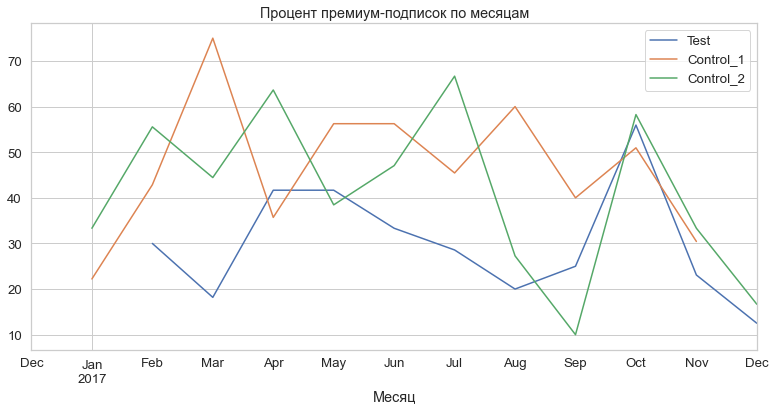

In [274]:
# Визуализация по месяцам
test_premium_conversion_by_month = (
    transactions_test[transactions_test.product_type=='premium_no_trial']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_test.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2)

control_1_premium_conversion_by_month = (
    transactions_control_1[transactions_control_1.product_type=='premium_no_trial']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_1.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2)

control_2_premium_conversion_by_month = (
    transactions_control_2[transactions_control_2.product_type=='premium_no_trial']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_2.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2)


test_premium_conversion_by_month.plot()
control_1_premium_conversion_by_month.plot()
control_2_premium_conversion_by_month.plot()
plt.legend(['Test', 'Control_1', 'Control_2'])
plt.title('Процент премиум-подписок по месяцам')
plt.xlabel('Месяц');

In [190]:
# Конверсия в премиум-подписку с разбивкой по месяцам в виде таблицы.
premium_conversion_by_month = (
    test_premium_conversion_by_month.to_frame().reset_index()
    .merge(control_1_premium_conversion_by_month.to_frame().reset_index(), on='paid_at')
    .merge(control_2_premium_conversion_by_month.to_frame().reset_index(), on='paid_at')
    .rename(columns={'uid_x': 'Test', 'uid_y': 'Control_1', 'uid': 'Control_2'})
    )
premium_conversion_by_month

,paid_at,Test,Control_1,Control_2
0,2017-01-31,NaN,22.22,33.33
1,2017-02-28,30.00,42.86,55.56
2,2017-03-31,18.18,75.00,44.44
3,2017-04-30,41.67,35.71,63.64
4,2017-05-31,41.67,56.25,38.46
5,2017-06-30,33.33,56.25,47.06
6,2017-07-31,28.57,45.45,66.67
7,2017-08-31,20.00,60.00,27.27
8,2017-09-30,25.00,40.00,10.00
9,2017-10-31,55.95,50.96,58.25


Процент пользователей, совершивших покупку в тестовой группе меньше, чем в обеих контрольных группах (на 1,06% меньше, чем в первой и на 1% чем во второй). Так же и процент покупателей, которые приобрели премиум-подписку в тестовой группе меньше, чем в контрольных (на 2,42% в первой и на 5,17% во второй контрольных группах). И такая тенденцеия, более или менее, сохраняется на протяжении всего периода.

1.7 Конверсия в пробную премиум-подписку

In [191]:
test_trial_conversion = test_trial / test_customer
control_1_trial_conversion = control_1_trial / control_1_customer
control_2_trial_conversion = control_2_trial / control_2_customer
print(f'В тестовой группе пробную премиум-подписку приобрели\t\t {test_trial_conversion:.2%} покупателей.')
print(f'В первой контрольной группе пробную премиум-подписку приобрели\t {control_1_trial_conversion:.2%} покупателей.')
print(f'Во второй контрольной группе пробную премиум-подписку приобрели\t {control_2_trial_conversion:.2%} покупателей.')

В тестовой группе пробную премиум-подписку приобрели		 42.47% покупателей.
В первой контрольной группе пробную премиум-подписку приобрели	 34.72% покупателей.
Во второй контрольной группе пробную премиум-подписку приобрели	 28.34% покупателей.


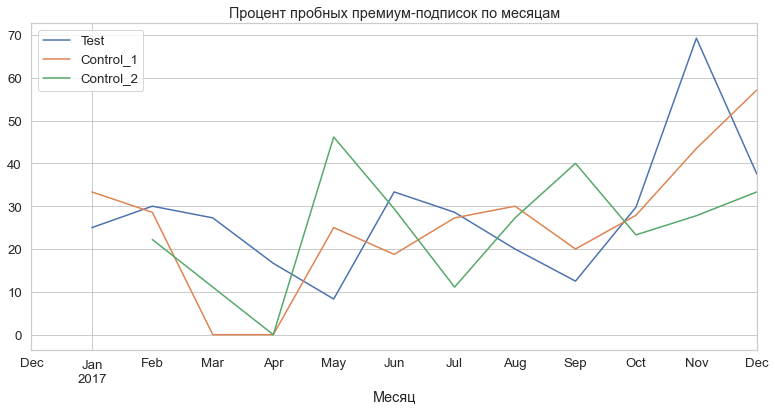

In [192]:
# Визуализация по месяцам
(transactions_test[transactions_test.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_test.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2).plot()
(transactions_control_1[transactions_control_1.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_1.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2).plot()
(transactions_control_2[transactions_control_2.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_2.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2).plot()
plt.legend(['Test', 'Control_1', 'Control_2'])
plt.title('Процент пробных премиум-подписок по месяцам')
plt.xlabel('Месяц');

In [193]:
# Конверсия в премиум-подписку с разбивкой по месяцам в виде таблицы.
trial_conversion_by_month = (
    (transactions_test[transactions_test.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_test.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2).
    to_frame().reset_index()
    .merge((transactions_control_1[transactions_control_1.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_1.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2)
    .to_frame().reset_index(), on='paid_at')
    .merge((transactions_control_2[transactions_control_2.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').uid.count() / transactions_control_2.set_index('paid_at')
    .resample('m').uid.nunique()
    ).mul(100).round(2)
    .to_frame().reset_index(), on='paid_at')
    .rename(columns={'uid_x': 'Test', 'uid_y': 'Control_1', 'uid': 'Control_2'})
    )
trial_conversion_by_month

,paid_at,Test,Control_1,Control_2
0,2017-01-31,25.00,33.33,NaN
1,2017-02-28,30.00,28.57,22.22
2,2017-03-31,27.27,0.00,11.11
3,2017-04-30,16.67,0.00,0.00
4,2017-05-31,8.33,25.00,46.15
5,2017-06-30,33.33,18.75,29.41
6,2017-07-31,28.57,27.27,11.11
7,2017-08-31,20.00,30.00,27.27
8,2017-09-30,12.50,20.00,40.00
9,2017-10-31,29.76,27.88,23.30


Отметим, что процент покупателей, которые приобрели пробную премиум-подписку в тестовой группе выше, чем в обеих контрольных группах (на 7,75% чем в первой контрольной группе и на 14,13%, чем во второй), в целом, эта тенденция сохраняется на протяжении всего периода.

1.8 Повторные покупки.

In [194]:
PR_test = transactions_test.uid.count()/test_customer
PR_control_1 = transactions_control_1.uid.count()/control_1_customer
PR_control_2 = transactions_control_2.uid.count()/control_2_customer
print(f'Повторные премиум-подписки в тестовой группе\t\t {round(PR_test, 2)}.')
print(f'Повторные премиум-подписки в первой контрольной группе\t {round(PR_control_1, 2)}.')
print(f'Повторные премиум-подписки во второй контрольной группе\t {round(PR_control_2, 2)}.')

Повторные премиум-подписки в тестовой группе		 1.87.
Повторные премиум-подписки в первой контрольной группе	 1.95.
Повторные премиум-подписки во второй контрольной группе	 1.75.


В тестовой группе повторых подписок меньше, чем в первой контрольной группе (в которой пользователей больше) на 0,08, но на 0,12 больше, чем во второй контрольной группе (конторая меньше, чем тестовая).

1.9 Повторные премиум-подписки.

In [195]:
PR_test_premium = test_premium/transactions_test[transactions_test.product_type=='premium_no_trial'].uid.nunique()
PR_control_1_premium = control_1_premium/transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].uid.nunique()
PR_control_2_premium = control_2_premium/transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].uid.nunique()
print(f'Повторные премиум-подписки в тестовой группе\t\t {round(PR_test_premium, 2)}.')
print(f'Повторные премиум-подписки в первой контрольной группе\t {round(PR_control_1_premium, 2)}.')
print(f'Повторные премиум-подписки во второй контрольной группе\t {round(PR_control_2_premium, 2)}.')

Повторные премиум-подписки в тестовой группе		 1.13.
Повторные премиум-подписки в первой контрольной группе	 1.07.
Повторные премиум-подписки во второй контрольной группе	 1.05.


В тестовой группе повторных премиум-подписок больше, чем в первой (на 0,06) и во второй (0,08) контрольных группах.

1.10 Повторные пробные премиум-подписки

In [196]:
PR_test_trial = test_trial/transactions_test[transactions_test.product_type=='trial_premium'].uid.nunique()
PR_control_1_trial = control_1_trial/transactions_control_1[transactions_control_1.product_type=='trial_premium'].uid.nunique()
PR_control_2_trial = control_2_trial/transactions_control_2[transactions_control_2.product_type=='trial_premium'].uid.nunique()
print(f'Повторные пробные премиум-подписки в тестовой группе\t\t {round(PR_test_trial, 2)}.')
print(f'Повторные пробные премиум-подписки в первой контрольной группе\t {round(PR_control_1_trial, 2)}.')
print(f'Повторные пробные премиум-подписки во второй контрольной группе\t {round(PR_control_2_trial, 2)}.')

Повторные пробные премиум-подписки в тестовой группе		 1.02.
Повторные пробные премиум-подписки в первой контрольной группе	 1.0.
Повторные пробные премиум-подписки во второй контрольной группе	 1.0.


Повторные пробные премиум-подписки были только в тестовой группе.

In [197]:
# Пользователи, совершившие повторыне подписки в тестовой группе.
(transactions_test.groupby('uid')
 .agg({'product_type': 'value_counts'})
 .rename(columns={'product_type': 'count'})
 .reset_index()
 .query('product_type==("premium_no_trial", "trial_premium")  & count>1')
)

,uid,product_type,count
21,891297711,trial_premium,2
84,891725043,premium_no_trial,2
97,891861048,premium_no_trial,2
140,892065108,premium_no_trial,3
149,892097937,premium_no_trial,3
175,892261437,premium_no_trial,2
181,892339626,premium_no_trial,3


In [198]:
# Пользователи, совершившие повторыне подписки в первой контрольной группе.
(transactions_control_1.groupby('uid')
 .agg({'product_type': 'value_counts'})
 .rename(columns={'product_type': 'count'})
 .reset_index()
 .query('product_type==("premium_no_trial", "trial_premium")  & count>1')
)

,uid,product_type,count
15,891216033.0,premium_no_trial,2
28,891264903.0,premium_no_trial,2
142,891822480.0,premium_no_trial,2
192,892101909.0,premium_no_trial,2
235,892290105.0,premium_no_trial,2
250,892366260.0,premium_no_trial,2
253,892393119.0,premium_no_trial,2


In [199]:
# # Пользователи, совершившие повторыне подписки во второй контрольной группе.
(transactions_control_2.groupby('uid')
 .agg({'product_type': 'value_counts'})
 .rename(columns={'product_type': 'count'})
 .reset_index()
 .query('product_type==("premium_no_trial", "trial_premium")  & count>1')
)

,uid,product_type,count
19,891219540,premium_no_trial,2
81,891637005,premium_no_trial,2
198,892139829,premium_no_trial,3
254,892435536,premium_no_trial,2


In [200]:
pd.DataFrame({
        'Grupps': ['Test', 'Control_1', 'Control_2'],
        'Users':[test_unique, control_1_unique, control_2_unique],
        'Customers':[test_customer, control_1_customer, control_2_customer],
        'Premium':[test_premium, control_1_premium, control_2_premium],
        'Trial': [test_trial, control_1_trial, control_2_trial],
        'CR': [test_conversion*100, control_1_conversion*100, control_2_conversion*100],
        'Premium_CR':[test_premium_conversion*100, control_1_premium_conversion*100, control_2_premium_conversion*100],    
        'Trial_CR': [test_trial_conversion*100, control_1_trial_conversion*100, control_2_trial_conversion*100],
        'PR': [PR_test, PR_control_1, PR_control_2],
        'PR_premium': [PR_test_premium, PR_control_1_premium, PR_control_2_premium],
        'PR_trial': [PR_test_trial, PR_control_1_trial, PR_control_2_trial]
}).style.hide_index()

Grupps,Users,Customers,Premium,Trial,CR,Premium_CR,Trial_CR,PR,PR_premium,PR_trial
Test,4308,146,76,62,3.389044,52.054795,42.465753,1.869863,1.134328,1.016393
Control_1,4340,193,106,67,4.447005,54.922280,34.715026,1.953368,1.070707,1.000000
Control_2,4264,187,107,53,4.385553,57.219251,28.342246,1.754011,1.049020,1.000000


### Вывод:
В первую очередь обращает на себя внимание то, что в тестовой группе наблюдается заметное снижение, числа покупателей (на 32% по сравнению с первой контрольной группой и на 28% по сравнению со второй), причем это снижение происходит за счет уменьшения числа премиум-подписок (на 39% по сравнению с первой контрольной группой и на 41% по сравнению со второй контрольной группой). Уменьшение числа покупателей привело и к уменьшению конверсий пользователя в покупателя и покупателя в премиум-подписку. В отношении пробной премиум-подписки, цена на которую в тестовой группе не менялась, такой тенденции не наблюдается. Хотя число пробных подписок в тестовой группе меньше, чем в первой контрольной (на 8%), зато их больше. чем во второй контрольной группе (на 14,5%) и конверсия покупателя в пробную премиум-подписку в тестовой группе больше, чем в обеих контрольных. Стоит также отметить, что, хотя повторных подписок в тестовой группе было меньше, чем в первой и больше, чем во второй контрольных группах, в тестовой группе и повторных премиум-подписок и повторных пробных подписок, больше, чем во обеих группах.

### 2. Оценка выручки и среднего дохода с пользователя и покупателя.

2.1 Описательные статистики для покупок во всех группах.

In [201]:
# Тестовая группа.
transactions_test.revenue.describe()

count       273.000000
mean       8589.380952
std       11127.479971
min         533.000000
25%        2743.000000
50%        6305.000000
75%       12597.000000
max      113477.000000
Name: revenue, dtype: float64

In [202]:
# Первая контрольная группа.
transactions_control_1.revenue.describe()

count      377.000000
mean      6929.206897
std       8027.889630
min         26.000000
25%       2730.000000
50%       6266.000000
75%       6448.000000
max      63037.000000
Name: revenue, dtype: float64

In [203]:
# Вторая контрольная группа.
transactions_control_2.revenue.describe()

count      328.000000
mean      5854.993902
std       6582.242539
min        481.000000
25%       2323.750000
50%       4706.000000
75%       6314.750000
max      81796.000000
Name: revenue, dtype: float64

2.2. Распределение выручки в разных группах.

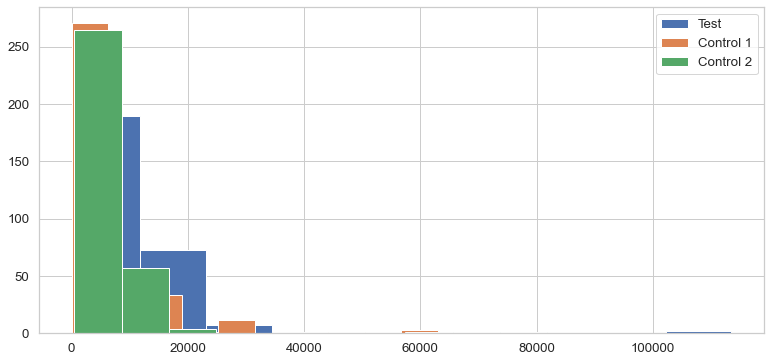

In [204]:
transactions_test.revenue.hist()
transactions_control_1.revenue.hist()
transactions_control_2.revenue.hist()
plt.legend(['Test', 'Control 1', 'Control 2']);

 2.2 Объем выручки в разных группах

In [205]:
test_revenue = transactions_test.revenue.sum()
control_1_revenue = transactions_control_1.revenue.sum()
control_2_revenue = transactions_control_2.revenue.sum()
print(f'Объем выручки в тестовой группе\t\t  {test_revenue}.')
print(f'Объем выручки в первой контрольной группе {control_1_revenue}.')
print(f'Объем выручки в второй контрольной группе {control_2_revenue}.')

Объем выручки в тестовой группе		  2344901.
Объем выручки в первой контрольной группе 2612311.0.
Объем выручки в второй контрольной группе 1920438.


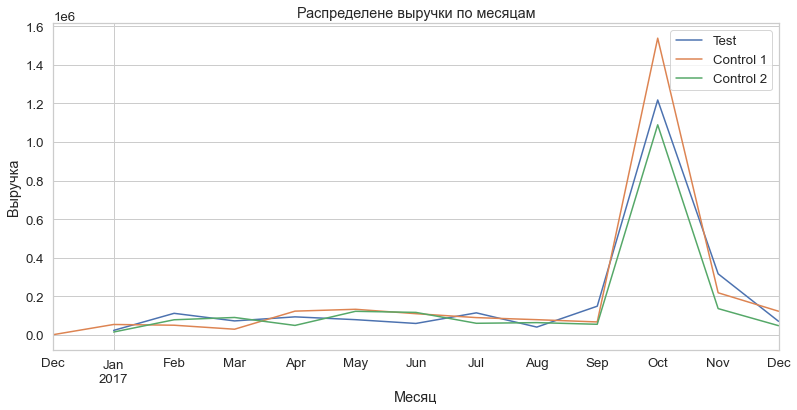

In [206]:
# Распределение по месяцам.
transactions_test.set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_1.set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_2.set_index('paid_at').resample('m').revenue.sum().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределене выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [207]:
# Распеределение выручки по месяцам в табличном виде. 
(
    transactions_test.set_index('paid_at').resample('m').revenue.sum().to_frame().reset_index()
.merge(transactions_control_1.set_index('paid_at').resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.merge(transactions_control_2.set_index('paid_at').resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-01-31,23010,53677.0,14534
1,2017-02-28,111527,49842.0,78091
2,2017-03-31,72163,29120.0,90038
3,2017-04-30,93236,122863.0,48815
4,2017-05-31,78676,132457.0,121940
5,2017-06-30,59020,109655.0,116324
6,2017-07-31,113997,89349.0,59865
7,2017-08-31,40170,78598.0,63297
8,2017-09-30,148538,66833.0,54717
9,2017-10-31,1218152,1538732.0,1089348


Таким образом, выручка в первой контрольной группе больше, чем в тестовой группе на 267410 (на 11%), и во второй контрольной группе на 424463 меньше (-18%), чем в тестовой группе

2.3 Средней чек.

In [208]:
test_revenue_mean = transactions_test.revenue.mean()
control_1_revenue_mean = transactions_control_1.revenue.mean()
control_2_revenue_mean = transactions_control_2.revenue.mean()
print(f'Средний чек в тестовой группе\t\t {round(test_revenue_mean)}.')
print(f'Средний чек в первой контрольной группе\t {round(control_1_revenue_mean)}.')
print(f'Средний чек в второй контрольной группе\t {round(control_2_revenue_mean)}.')

Средний чек в тестовой группе		 8589.
Средний чек в первой контрольной группе	 6929.
Средний чек в второй контрольной группе	 5855.


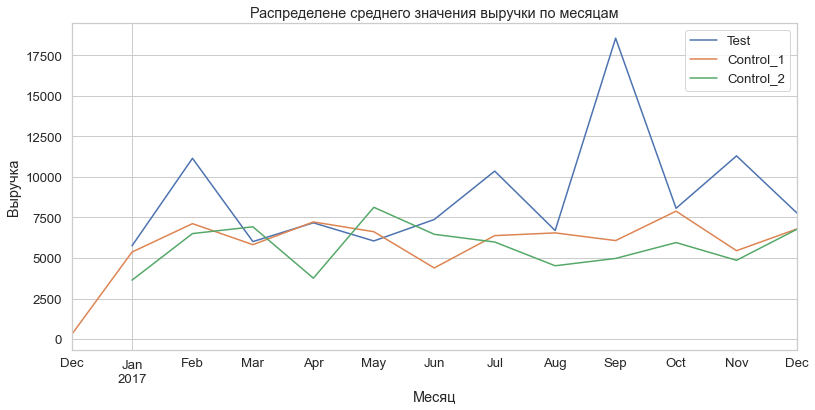

In [209]:
# Средний чек с разбивкой по месяцам.
transactions_test.set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_1.set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_2.set_index('paid_at').resample('m').revenue.mean().plot()
plt.legend(['Test', 'Control_1', 'Control_2'])
plt.title('Распределене среднего значения выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [210]:
# Распеределение среднего чека по месяцам в табличном виде. 
(
    transactions_test.set_index('paid_at').resample('m').revenue.mean().to_frame().reset_index().round(2)
.merge(transactions_control_1.set_index('paid_at').resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.merge(transactions_control_2.set_index('paid_at').resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-01-31,5752.50,5367.70,3633.50
1,2017-02-28,11152.70,7120.29,6507.58
2,2017-03-31,6013.58,5824.00,6926.00
3,2017-04-30,7172.00,7227.24,3755.00
4,2017-05-31,6052.00,6622.85,8129.33
5,2017-06-30,7377.50,4386.20,6462.44
6,2017-07-31,10363.36,6382.07,5986.50
7,2017-08-31,6695.00,6549.83,4521.21
8,2017-09-30,18567.25,6075.73,4974.27
9,2017-10-31,8067.23,7890.93,5952.72


Средний чек в тестовой группе больше чем в обеих контрольных группах, на 1660 (на 20%), чем в первой и на 2734 (32%), чем во второй.

2.4 Объем выручки от премиум подписки.

In [211]:
test_revenue_premium = transactions_test[transactions_test.product_type=='premium_no_trial'].revenue.sum()
control_1_revenue_premium = transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].revenue.sum()
control_2_revenue_premium = transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].revenue.sum()
print(f'Объем выручки от премиум подписки в тестовой группе\t\t {test_revenue_premium}.')
print(f'Объем выручки от премиум подписки в первой контрольной группе\t {control_1_revenue_premium}.')
print(f'Объем выручки от премиум подписки в второй контрольной группе\t {control_2_revenue_premium}.')

Объем выручки от премиум подписки в тестовой группе		 810706.
Объем выручки от премиум подписки в первой контрольной группе	 779259.0.
Объем выручки от премиум подписки в второй контрольной группе	 744809.


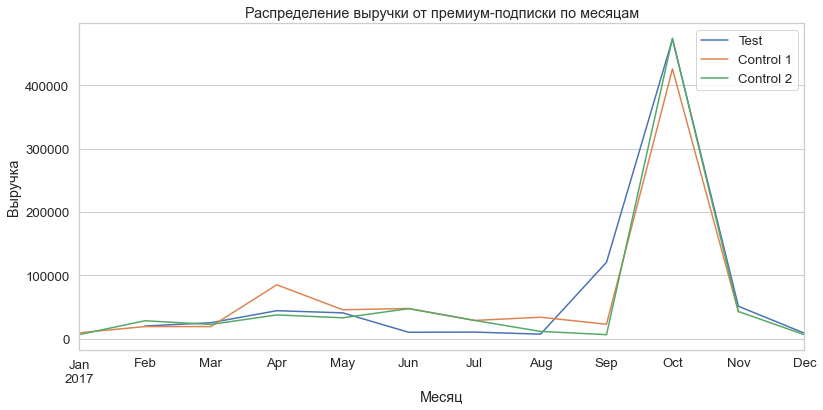

In [212]:
# Распределение по месяцам.
transactions_test[transactions_test.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.sum().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение выручки от премиум-подписки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [213]:
# Распеределение выручки от премиум-подписки по месяцам в табличном виде. 
(
    transactions_test[transactions_test.product_type=='premium_no_trial']
    .set_index('paid_at')
    .resample('m').revenue.sum().to_frame().reset_index()
.merge(transactions_control_1[transactions_control_1.product_type=='premium_no_trial']
       .set_index('paid_at')
       .resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.merge(transactions_control_2[transactions_control_2.product_type=='premium_no_trial']
       .set_index('paid_at').resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-02-28,19903,19084.0,28249
1,2017-03-31,25194,19032.0,22425
2,2017-04-30,44148,85046.0,37479
3,2017-05-31,40729,45656.0,32903
4,2017-06-30,10062,47619.0,47398
5,2017-07-31,10348,28756.0,28782
6,2017-08-31,7098,33839.0,11427
7,2017-09-30,120575,22750.0,6292
8,2017-10-31,472797,425945.0,474448
9,2017-11-30,51155,42354.0,42835


Выручка от премиум-подписки в тестовой группе выше, чем в обеих контрольных группах, на 31447 (4%), чем в первой и на 65897 (8%), чем во второй.

2.5 Средний чек премиум-подписки.

In [214]:
test_revenue_premium_mean = transactions_test[transactions_test.product_type=='premium_no_trial'].revenue.mean()
control_1_revenue_premium_mean = transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].revenue.mean()
control_2_revenue_premium_mean = transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].revenue.mean()
print(f'Средний чек от премиум подписки в тестовой группе\t\t {round(test_revenue_premium_mean)}.')
print(f'Средний чек от премиум подписки в первой контрольной группе\t {round(control_1_revenue_premium_mean)}.')
print(f'Средний чек от премиум подписки в второй контрольной группе\t {round(control_2_revenue_premium_mean)}.')

Средний чек от премиум подписки в тестовой группе		 10667.
Средний чек от премиум подписки в первой контрольной группе	 7352.
Средний чек от премиум подписки в второй контрольной группе	 6961.


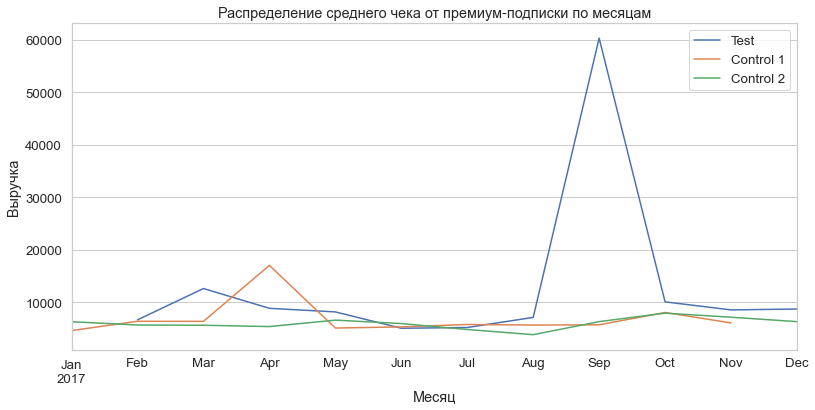

In [215]:
# Распределение по месяцам.
transactions_test[transactions_test.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].set_index('paid_at').resample('m').revenue.mean().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение среднего чека от премиум-подписки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [216]:
# Распеределение среднего чека от премиум-подписки по месяцам в табличном виде. 
(
    transactions_test[transactions_test.product_type=='premium_no_trial']
    .set_index('paid_at')
    .resample('m').revenue.mean().to_frame().reset_index().round(2)
.merge(transactions_control_1[transactions_control_1.product_type=='premium_no_trial']
       .set_index('paid_at')
       .resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.merge(transactions_control_2[transactions_control_2.product_type=='premium_no_trial']
       .set_index('paid_at').resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-02-28,6634.33,6361.33,5649.80
1,2017-03-31,12597.00,6344.00,5606.25
2,2017-04-30,8829.60,17009.20,5354.14
3,2017-05-31,8145.80,5072.89,6580.60
4,2017-06-30,5031.00,5291.00,5924.75
5,2017-07-31,5174.00,5751.20,4797.00
6,2017-08-31,7098.00,5639.83,3809.00
7,2017-09-30,60287.50,5687.50,6292.00
8,2017-10-31,10059.51,8036.70,7907.47
9,2017-11-30,8525.83,6050.57,7139.17


Средний чек от премиум-подписки в тествой группе больше, чем в обеих контрольных, на 3315 (на 31%), чем в первой и на 3706 (35%), чем во второй.

2.6 Объем выручки от пробной премиум-подписки

In [217]:
test_revenue_trial = transactions_test[transactions_test.product_type=='trial_premium'].revenue.sum()
control_1_revenue_trial = transactions_control_1[transactions_control_1.product_type=='trial_premium'].revenue.sum()
control_2_revenue_trial = transactions_control_2[transactions_control_2.product_type=='trial_premium'].revenue.sum()
print(f'Объем выручки от пробной премиум-подписки в тестовой группе\t\t {test_revenue_trial}.')
print(f'Объем выручки от пробной премиум-подписки в первой контрольной группе\t {control_1_revenue_trial}.')
print(f'Объем выручки от пробной премиум-подписки в второй контрольной группе\t {control_2_revenue_trial}.')

Объем выручки от пробной премиум-подписки в тестовой группе		 800202.
Объем выручки от пробной премиум-подписки в первой контрольной группе	 772720.0.
Объем выручки от пробной премиум-подписки в второй контрольной группе	 643981.


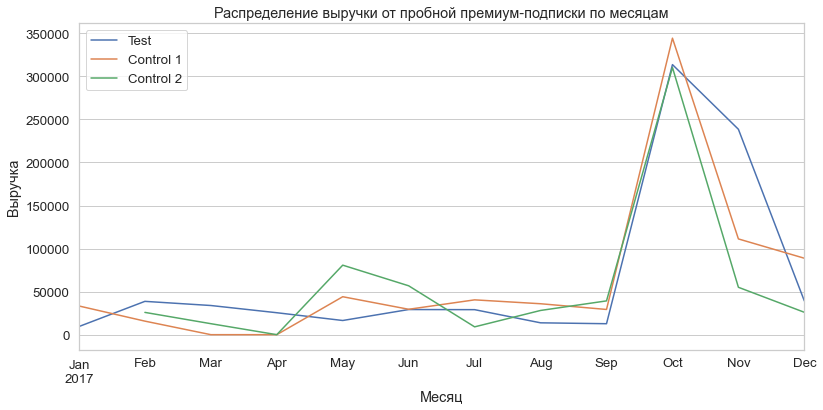

In [218]:
# Распределение по месяцам.
transactions_test[transactions_test.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_1[transactions_control_1.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.sum().plot()
transactions_control_2[transactions_control_2.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.sum().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение выручки от пробной премиум-подписки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [219]:
# Распеределение выручки от пробной премиум-подписки по месяцам в табличном виде. 
(
    transactions_test[transactions_test.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').revenue.sum().to_frame().reset_index()
.merge(transactions_control_1[transactions_control_1.product_type=='trial_premium']
       .set_index('paid_at')
       .resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.merge(transactions_control_2[transactions_control_2.product_type=='trial_premium']
       .set_index('paid_at').resample('m').revenue.sum().to_frame().reset_index(), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-02-28,38701,15730.0,25883
1,2017-03-31,33878,0.0,12766
2,2017-04-30,25493,0.0,0
3,2017-05-31,16471,44083.0,80743
4,2017-06-30,29198,29497.0,56771
5,2017-07-31,29055,40443.0,9087
6,2017-08-31,13767,35932.0,28132
7,2017-09-30,12727,29289.0,39247
8,2017-10-31,313690,344409.0,310310
9,2017-11-30,238576,111215.0,55042


Выручка от пробной премиум-подписки в тестовой труппе была выше, чем в обеих контрольных группах, на 27482 (3%), чем в перовой и на 156221 (20%), чем во второй.

2.6 Средний чек от пробной премиум-подписки

In [220]:
test_revenue_trial_mean = transactions_test[transactions_test.product_type=='trial_premium'].revenue.mean()
control_1_revenue_trial_mean = transactions_control_1[transactions_control_1.product_type=='trial_premium'].revenue.mean()
control_2_revenue_trial_mean = transactions_control_2[transactions_control_2.product_type=='trial_premium'].revenue.mean()
print(f'Средний чек от пробной премиум подписки в тестовой группе\t\t {round(test_revenue_trial_mean)}.')
print(f'Средний чек от пробной премиум подписки в первой контрольной группе\t {round(control_1_revenue_trial_mean)}.')
print(f'Средний чек от пробной премиум подписки в второй контрольной группе\t {round(control_2_revenue_trial_mean)}.')

Средний чек от пробной премиум подписки в тестовой группе		 12906.
Средний чек от пробной премиум подписки в первой контрольной группе	 11533.
Средний чек от пробной премиум подписки в второй контрольной группе	 12151.


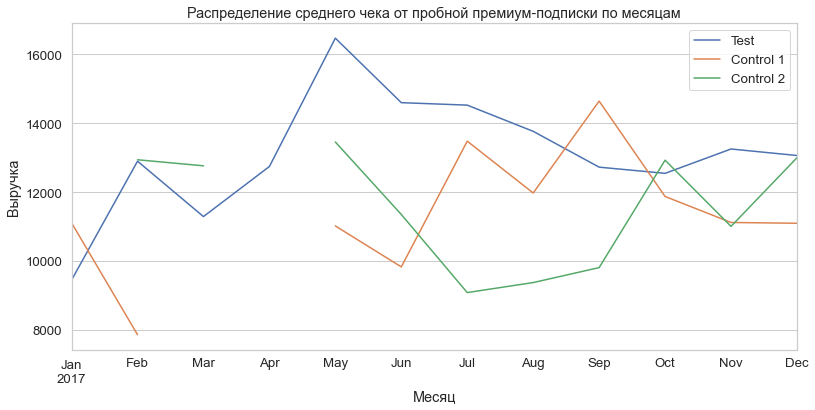

In [221]:
# Распределение по месяцам.
transactions_test[transactions_test.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_1[transactions_control_1.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.mean().plot()
transactions_control_2[transactions_control_2.product_type=='trial_premium'].set_index('paid_at').resample('m').revenue.mean().plot()
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Распределение среднего чека от пробной премиум-подписки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

In [222]:
# Распеределение среднего чека от пробной премиум-подписки по месяцам в табличном виде. 
(
    transactions_test[transactions_test.product_type=='trial_premium']
    .set_index('paid_at')
    .resample('m').revenue.mean().to_frame().reset_index().round(2)
.merge(transactions_control_1[transactions_control_1.product_type=='trial_premium']
       .set_index('paid_at')
       .resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.merge(transactions_control_2[transactions_control_2.product_type=='trial_premium']
       .set_index('paid_at').resample('m').revenue.mean().to_frame().reset_index().round(2), on='paid_at')
.rename(columns={'revenue_x': 'Test', 'revenue_y': 'Control_1', 'revenue': 'Control_2'})
)

,paid_at,Test,Control_1,Control_2
0,2017-02-28,12900.33,7865.00,12941.50
1,2017-03-31,11292.67,NaN,12766.00
2,2017-04-30,12746.50,NaN,NaN
3,2017-05-31,16471.00,11020.75,13457.17
4,2017-06-30,14599.00,9832.33,11354.20
5,2017-07-31,14527.50,13481.00,9087.00
6,2017-08-31,13767.00,11977.33,9377.33
7,2017-09-30,12727.00,14644.50,9811.75
8,2017-10-31,12547.60,11876.17,12929.58
9,2017-11-30,13254.22,11121.50,11008.40


Средний чек от пробной премиум-подписки в тестовой группе больше, чем в обеих контрольных, на 1373 (11%) чем в первой и на 755 (6%) чем во второй.

2.7 Средний доход на пользователя.

In [223]:
ARPU_test = test_revenue/test_unique
ARPU_control_1 = control_1_revenue/control_1_unique
ARPU_control_2 = control_2_revenue/control_2_unique
print(f'Средний доход на пользователя в тестовой группе\t\t\t {round(ARPU_test)}.')
print(f'Средний доход на пользователя в первой контрольной группе\t {round(ARPU_control_1)}.')
print(f'Средний доход на пользователя во второй контрольной группе\t {round(ARPU_control_2)}.')

Средний доход на пользователя в тестовой группе			 544.
Средний доход на пользователя в первой контрольной группе	 602.
Средний доход на пользователя во второй контрольной группе	 450.


Средний доход на пользователя в тествой группе меньше, чем в певрвой контрольной на на 58 (т. е на 11%) и на 94 (т. е на 17%) больше, чем во второй контрльной группе.

2.8 Средний доход на платящего пользователя (покупателя) по всем группам.

In [224]:
ARPPU_test = test_revenue/test_customer
ARPPU_control_1 = control_1_revenue/control_1_customer
ARPPU_control_2 = control_2_revenue/control_2_customer
print(f'Средний доход на покупателя в тестовой группе\t\t {round(ARPPU_test)}')
print(f'Средний доход на покупателя в первой контрольной группе\t {round(ARPPU_control_1)}')
print(f'Средний доход на покупателя во второй контрольной группе {round(ARPPU_control_2)}')

Средний доход на покупателя в тестовой группе		 16061
Средний доход на покупателя в первой контрольной группе	 13535
Средний доход на покупателя во второй контрольной группе 10270


Средний доход на покупателя в тестовой группе больше, чем во обеих контрольных группах, на 2526 (т. е. на 16%) для первой группы, и на 5791 (т. е. на 36%) для второй.

2.9 средний доход на покупателя для приемиум-подписки.

In [225]:
ARPPU_test_premium = test_revenue_premium/test_premium
ARPPU_control_1_premium = control_1_revenue_premium/control_1_premium
ARPPU_control_2_premium = control_2_revenue_premium/control_2_premium
print(f'Средний доход на покупателя для премиум-подписки в тестовой группе\t\t {round(ARPPU_test_premium)}')
print(f'Средний доход на покупателя для премиум-подписки в первой контрольной группе\t {round(ARPPU_control_1_premium)}')
print(f'Средний доход на покупателя для премиум-подписки во второй контрольной группе\t {round(ARPPU_control_2_premium)}')

Средний доход на покупателя для премиум-подписки в тестовой группе		 10667
Средний доход на покупателя для премиум-подписки в первой контрольной группе	 7352
Средний доход на покупателя для премиум-подписки во второй контрольной группе	 6961


Средний доход на покупателя премиум-подписки в тестовой групее больше чем в обеих группах, на 3315 (т. е. на 31%) для первой группы и на 3706 (т. е. на 35%) для второй.

2.10 Средний доход на покупателя для пробной премиум-подписки

In [226]:
ARPPU_test_trial = test_revenue_trial/test_trial
ARPPU_control_1_trial = control_1_revenue_trial/control_1_trial
ARPPU_control_2_trial = control_2_revenue_trial/control_2_trial
print(f'Средний доход на покупателя для пробной премиум-подписки в тестовой группе\t\t {round(ARPPU_test_trial)}')
print(f'Средний доход на покупателя для пробной премиум-подписки в первой контрольной группе\t {round(ARPPU_control_1_trial)}')
print(f'Средний доход на покупателя для пробной премиум-подписки во второй контрольной группе\t {round(ARPPU_control_2_trial)}')

Средний доход на покупателя для пробной премиум-подписки в тестовой группе		 12906
Средний доход на покупателя для пробной премиум-подписки в первой контрольной группе	 11533
Средний доход на покупателя для пробной премиум-подписки во второй контрольной группе	 12151


Средний доход на покупателя пробной премим-подписки с тестовой группе больше, чем в обеих контрольных группах, на 1373 (т. е. на 11%) для первой и на 755 (т. е на 6%) для второй.

2.11 Сводная таблица.

In [227]:
pd.DataFrame({
        'Grupps': ['Test', 'Control_1', 'Control_2'],
        'Revenue':[test_revenue, control_1_revenue, control_2_revenue],    
        'Revenue_mean':[test_revenue_mean, control_1_revenue_mean, control_2_revenue_mean],
        'Revenue_premium':[test_revenue_premium, control_1_revenue_premium, control_2_revenue_premium],
        'Revenue_premium_mean': [test_revenue_premium_mean, control_1_revenue_premium_mean, control_2_revenue_premium_mean],
        'Revenue_trial': [test_revenue_trial, control_1_revenue_trial, control_2_revenue_trial],
        'Revenue_trial_mean':[test_revenue_trial_mean, control_1_revenue_trial_mean, control_2_revenue_trial_mean],
        'ARPU': [ARPU_test, ARPU_control_1, ARPU_control_2],
        'ARPPU': [ARPPU_test, ARPPU_control_1, ARPPU_control_2],
        'ARPPU_premium': [ARPPU_test_premium, ARPPU_control_1_premium, ARPPU_control_2_premium],
        'ARPPU_trial' :[ARPPU_test_trial, ARPPU_control_1_trial, ARPPU_control_2_trial]
}).style.hide_index()

Grupps,Revenue,Revenue_mean,Revenue_premium,Revenue_premium_mean,Revenue_trial,Revenue_trial_mean,ARPU,ARPPU,ARPPU_premium,ARPPU_trial
Test,2344901.000000,8589.380952,810706.000000,10667.184211,800202.000000,12906.483871,544.313138,16060.965753,10667.184211,12906.483871
Control_1,2612311.000000,6929.206897,779259.000000,7351.500000,772720.000000,11533.134328,601.914977,13535.290155,7351.500000,11533.134328
Control_2,1920438.000000,5854.993902,744809.000000,6960.831776,643981.000000,12150.584906,450.384146,10269.721925,6960.831776,12150.584906


2.12 Проверка статистической значимости различий выручки в разных группах.

Для проверки стат. значимости различий выбран тест Манна-Уитни, так как распределение выручки во всех группах не является нормальным.

In [228]:
# U-тест Манна-Уитни межу тестовой и первой контрольнной группой
stats.mannwhitneyu(transactions_test.revenue, transactions_control_1.revenue)

MannwhitneyuResult(statistic=44780.0, pvalue=0.0023331842149903826)

In [229]:
# U-тест Манна-Уитни межу тестовой и второй контрольнной группой
stats.mannwhitneyu(transactions_test.revenue, transactions_control_2.revenue)

MannwhitneyuResult(statistic=36409.5, pvalue=3.934762581241497e-05)

In [230]:
# U-тест Манна-Уитни межу тестовой и первой контрольнной группой, премиум-подписка
stats.mannwhitneyu(transactions_test[transactions_test.product_type=='premium_no_trial'].revenue, 
                   transactions_control_1[transactions_control_1.product_type=='premium_no_trial'].revenue)

MannwhitneyuResult(statistic=2190.0, pvalue=6.003201777334211e-08)

In [231]:
# U-тест Манна-Уитни межу тестовой и второй контрольнной группой, премиум-подписка
stats.mannwhitneyu(transactions_test[transactions_test.product_type=='premium_no_trial'].revenue, 
                   transactions_control_2[transactions_control_2.product_type=='premium_no_trial'].revenue)

MannwhitneyuResult(statistic=2361.0, pvalue=5.687225669158821e-07)

In [232]:
# U-тест Манна-Уитни межу тестовой и певрой контрольнной группой, пробная премиум-подписка
stats.mannwhitneyu(transactions_test[transactions_test.product_type=='trial_premium'].revenue, 
                   transactions_control_1[transactions_control_1.product_type=='trial_premium'].revenue)

MannwhitneyuResult(statistic=1464.0, pvalue=0.001828475761023437)

In [233]:
# U-тест Манна-Уитни межу тестовой и второй контрольнной группой,пробная премиум-подписка
stats.mannwhitneyu(transactions_test[transactions_test.product_type=='trial_premium'].revenue, 
                   transactions_control_2[transactions_control_2.product_type=='trial_premium'].revenue)

MannwhitneyuResult(statistic=1328.5, pvalue=0.038011659674086935)

In [234]:
# Критерий Краскела — Уоллиса для проверки равенства медиан в трех группах.
stats.kruskal(transactions_test.revenue, transactions_control_1.revenue, transactions_control_2.revenue)

KruskalResult(statistic=16.39830275020846, pvalue=0.00027488674675515035)

In [235]:
# Критерий Тьюки для опредления того между какими-группами существуют с татистически значимые различия.
df = pd.concat([transactions_test.revenue, transactions_control_1.revenue, transactions_control_2.revenue], axis=1, keys=['Test', 'Control_1', 'Control_2']).dropna()
df = df.melt(var_name = 'groups')
MultiComp = MultiComparison(df.value, df.groups)
print(MultiComp.tukeyhsd().summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff p-adj    lower      upper   reject
----------------------------------------------------------------
Control_1 Control_2 -339.1905  0.878 -2053.2137 1374.8327  False
Control_1      Test 2328.0952 0.0042    614.072 4042.1184   True
Control_2      Test 2667.2857  0.001   953.2625 4381.3089   True
----------------------------------------------------------------


Различия распределения выручки во всех группах являются статистически значимыми.

### Вывод
Хотя общая выручка за все покупки в тестовой группе меньше, чем в первой контрольной группе (на 11%) и больше, чем во второй контрольной группе (на 18%), в отношении премиум-подписки и пробной премиум-подписки выручка в тестовой группе превышала тот же показатель для обеих контрольных групп. 
Средний чек в тестовой группе так же превышает этот показатель для обеих контрольных групп (что вполне ожидаемо для премиум-подписки, цена на которую была изменена, но заслуживает внимания, в отношении пробной подписки, цена на которую не менялась). 
Показатели ARPU и ARPPU отражают те же тенденции. 
ARPU как и выручка (а также число пользователей), в тестовой группе меньше, чем в первой контрольной , но больше, чем во второй. 
А ARPPU в тестовой группе выше, чем в обеих контрольных, как в целом, так и по подпискам.

### 3. Ретеншн

In [236]:
# Функция для определения ретеншна.
def get_retention(df):
    df = df.copy()
    df.visit_days = df.visit_days.str.split(',')
    df  = df.explode('visit_days').astype({'visit_days': 'float64'})
    retention = (df.visit_days.value_counts().to_frame().reset_index()
                      .rename(columns={'index': 'day', 'visit_days': 'visits'}).astype({'day': 'int64'}))
    retention['retention'] = round(retention.visits/df[df.visit_days>=1].uid.nunique()*100, 2)
    return retention

In [237]:
# Тестовая группа
test_retention = get_retention(users_test)
# Первая контрольная группа.
control_1_retention = get_retention(users_control_1)
# Вторая контрольная группа.
control_2_retention =  get_retention(users_control_2)

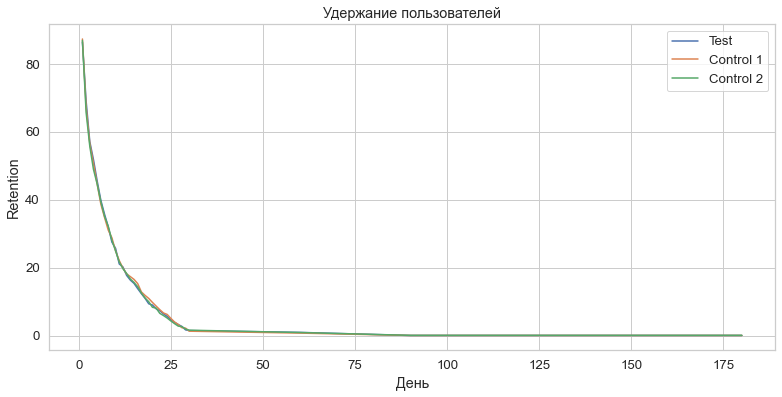

In [238]:
sns.lineplot(x ='day', y='retention', data=test_retention)
sns.lineplot(x ='day', y='retention', data=control_1_retention)
sns.lineplot(x ='day', y='retention', data=control_2_retention)
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Удержание пользователей')
plt.xlabel('День')
plt.ylabel('Retention');

In [239]:
# Немного изменим функцию, чтобы посчитать ретенш для покупателей.
def get_retention_customer(df):
    df = df.query("total_revenue > 0").copy()
    df.visit_days = df.visit_days.str.split(',')
    df  = df.explode('visit_days').astype({'visit_days': 'float64'})
    retention = (df.visit_days.value_counts().to_frame().reset_index()
                      .rename(columns={'index': 'day', 'visit_days': 'visits'}).astype({'day': 'int64'}))
    retention['retention'] = round(retention.visits/df.query('visit_days>=1 and total_revenue > 0').uid.nunique()*100, 2)
    return retention

In [240]:
# Тестовая группа
test_retention_customer = get_retention_customer(users_test)
# Первая контрольная группа.
control_1_retention_customer = get_retention_customer(users_control_1)
# Вторая контрольная группа.
control_2_retention_customer =  get_retention_customer(users_control_2)

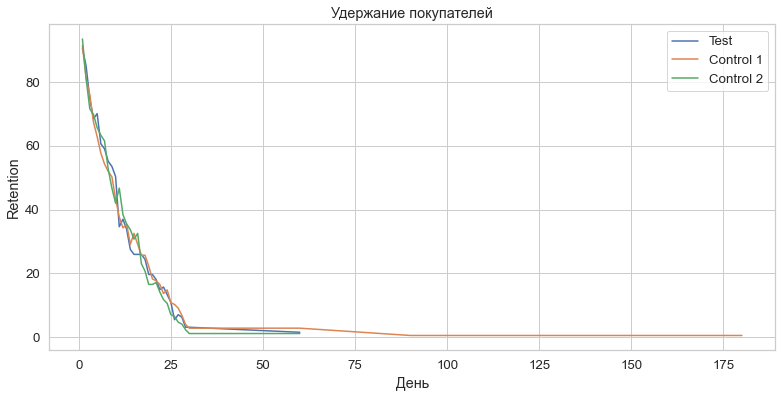

In [241]:
sns.lineplot(x ='day', y='retention', data=test_retention_customer)
sns.lineplot(x ='day', y='retention', data=control_1_retention_customer)
sns.lineplot(x ='day', y='retention', data=control_2_retention_customer)
plt.legend(['test', 'control_1', 'control_2'])
plt.legend(['Test', 'Control 1', 'Control 2'])
plt.title('Удержание покупателей')
plt.xlabel('День')
plt.ylabel('Retention');

Можно заметить, что как удержание пользователей, так и удержание покупателей во всех группах существенно не отличается, за исключением того факта, что удержание покупателей в тестовой и второй контрольной группах не превышает 60 дней. Следовательно, в отношении удержания пользователей, эксперимент можно считать успешным, так как изменение цены подписки не повлияло на посещение сайта пользователями, в том числе и совершившими покупки.

## Выводы: был ли эксперимент успешен
Эксперемент нельзя признать полностью успешным. Да, средний доход с покупателя, и для премиум-подписчиков в частности,  увеличился, но есть тенденция к тому, что покупатели все больше отдают предпочтение более дешевой пробной подписке, о чем говорит увеличение выручки и среднего доходха на покупателя пробной премиум-подписки, цена на которую в ходе эксперимента не менялась. 
Так же следует отметить, что общий объем выручки в тестовой группе больше, чем во второй (в которой меньше пользователей), но меньше, чем в первой контрольной группе (в которой больше пользователей).
В отношении привлечения новых покупателей эксперимент можно признать неудачным, так как число покупателей заметно снизилось (на 32% и 28%), это же касается и премиум-подписок (снижение на 39% и 41%). Что также привело к снижению конверсии.
На удержание пользователей (Retention), эксперимент не повлиял, что можно счиатать успехом.

## Имеет ли нововведение смысл среди каких-либо конкретных групп пользователей?

In [242]:
# Создание возрастных групп покупателей.
users_test['age_groups'] = pd.cut(users_test.age, bins=[0, 20, 30, 40, 50, users_test.age.max()], 
       labels=['less than 20 years', '20-30 years', '30-40 years', '40-50 years', 'more than 50 years'])
users_control_1['age_groups'] = pd.cut(users_control_1.age, bins=[0, 20, 30, 40, 50, users_control_1.age.max()], 
       labels=['less than 20 years', '20-30 years', '30-40 years', '40-50 years', 'more than 50 years'])
users_control_2['age_groups'] = pd.cut(users_control_2.age, bins=[0, 20, 30, 40, 50, users_control_2.age.max()], 
       labels=['less than 20 years', '20-30 years', '30-40 years', '40-50 years', 'more than 50 years'])

In [243]:
# объединение таблиц с данными о пользователях и данными о платежах.
test = users_test.merge(transactions_test, on=['uid', 'country'])
control_1 = users_control_1.merge(transactions_control_1, on=['uid', 'country'])
control_2 = users_control_2.merge(transactions_control_2, on=['uid', 'country'])

1. Пол

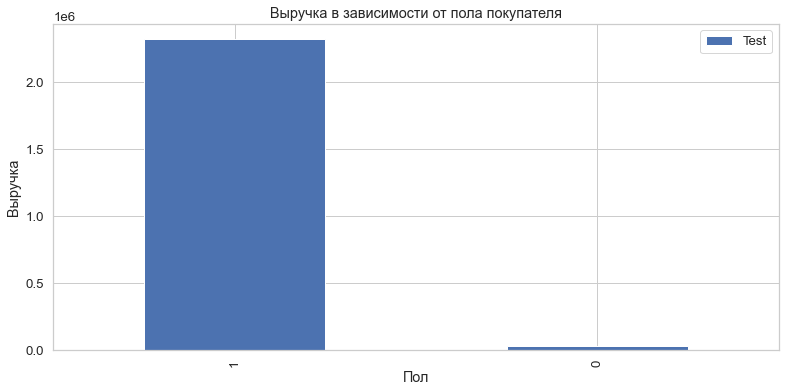

In [244]:
# Для тествой группы.
test.groupby('gender').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Test'])
plt.title('Выручка в зависимости от пола покупателя')
plt.xlabel('Пол')
plt.ylabel('Выручка');

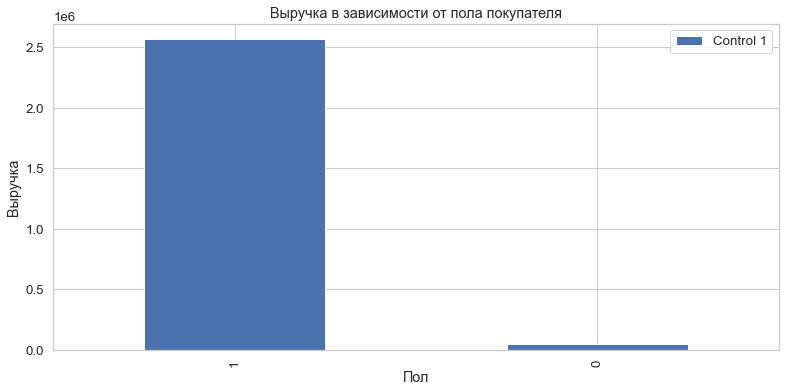

In [245]:
control_1.groupby('gender').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Control 1'])
plt.title('Выручка в зависимости от пола покупателя')
plt.xlabel('Пол')
plt.ylabel('Выручка');

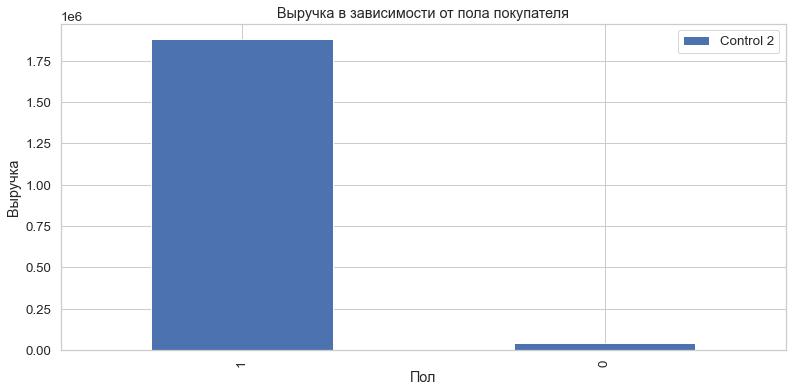

In [246]:
control_2.groupby('gender').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Control 2'])
plt.title('Выручка в зависимости от пола покупателя')
plt.xlabel('Пол')
plt.ylabel('Выручка');

In [247]:
# Число пользователей и покупателей разного пола, а также конверсия в тестовой группе.
test_gender = test.groupby('gender', as_index=False)\
               .agg({'uid': 'nunique'}).rename(columns={'uid' :'customer'})\
               .merge(users_test.groupby('gender', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='gender')
test_gender['conversion'] = round(test_gender.customer/test_gender.users*100, 2)
test_gender

,gender,customer,users,conversion
0,0,2,202,0.99
1,1,144,4106,3.51


In [248]:
# Число пользователей и покупателей разного пола, а также конверсия в первой контрольной группе.
control_1_gender = control_1.groupby('gender', as_index=False)\
               .agg({'uid': 'nunique'}).rename(columns={'uid' :'customer'})\
               .merge(users_control_1.groupby('gender', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='gender')
control_1_gender['conversion'] = round(control_1_gender.customer/control_1_gender.users*100, 2)
control_1_gender

,gender,customer,users,conversion
0,0,4,182,2.20
1,1,189,4158,4.55


In [249]:
# Число пользователей и покупателей разного пола, а также конверсия в первой контрольной группе.
control_2_gender = control_2.groupby('gender', as_index=False)\
               .agg({'uid': 'nunique'}).rename(columns={'uid' :'customer'})\
               .merge(users_control_2.groupby('gender', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='gender')
control_2_gender['conversion'] = round(control_2_gender.customer/control_2_gender.users*100, 2)
control_2_gender

,gender,customer,users,conversion
0,0,7,195,3.59
1,1,180,4069,4.42


Поскольку, во всех трех группах подавляющее большинство покупателей 1 пола, врядли можно сделать вывод о том, что нововведение каким-либо образом повлияло на поведение представителей разного пола. Однако, с осторожностью, можно сделать предпложение, что нововедение менее привлекательно для представителей пола 0, поскольку в тестовойт группе их всего 2, в то время как в контрольных группах их 4 и 7, в первой и второй соответствеено.

2. Страна

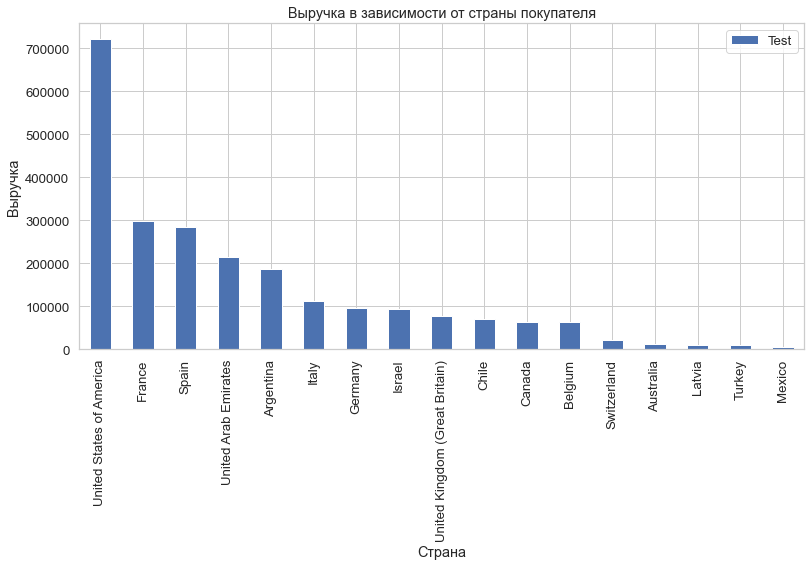

In [250]:
test.groupby('country').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Test'])
plt.title('Выручка в зависимости от страны покупателя')
plt.xlabel('Страна')
plt.ylabel('Выручка');


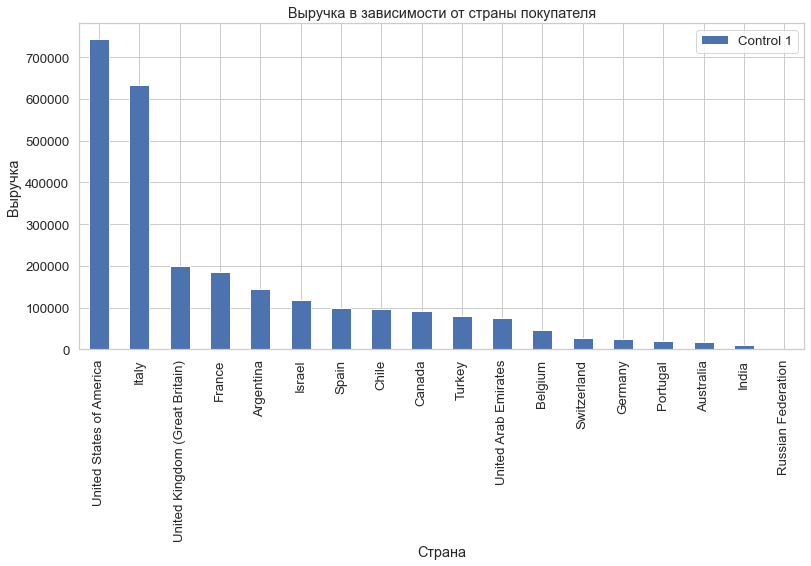

In [251]:
control_1.groupby('country').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Control 1'])
plt.title('Выручка в зависимости от страны покупателя')
plt.xlabel('Страна')
plt.ylabel('Выручка');

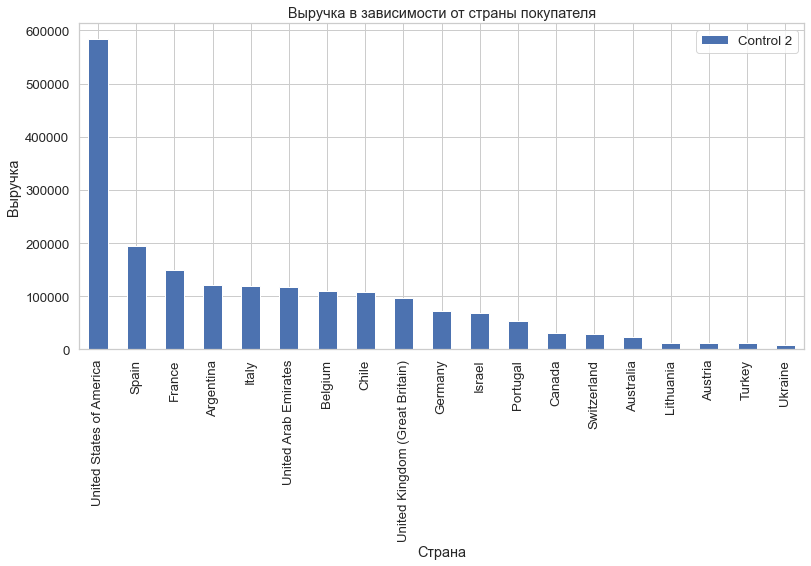

In [252]:
control_2.groupby('country').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Control 2'])
plt.title('Выручка в зависимости от страны покупателя')
plt.xlabel('Страна')
plt.ylabel('Выручка');

In [253]:
# Тестовая группа
test_country = test.groupby('country', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head(3)
test_country['ARPPU'] = round(test_country.revenue/test_country.uid)
test_country = test_country.merge(users_test.groupby('country', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='country')
test_country['conversion'] = round(test_country.uid/test_country.users*100, 2)
test_country.sort_values(by=['conversion', 'ARPPU'], ascending=False).rename(columns={'uid':'customers'})

,country,customers,revenue,ARPPU,users,conversion
2,Spain,15,285428,19029.0,301,4.98
1,France,13,297700,22900.0,359,3.62
0,United States of America,52,721838,13882.0,1450,3.59


In [254]:
# Первая контрольная группа
control_1_country = control_1.query('country==("France", "Spain", "United States of America")').groupby('country', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head(3)
control_1_country['ARPPU'] = round(control_1_country.revenue/control_1_country.uid)
control_1_country = control_1_country.merge(users_control_1.groupby('country', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='country')
control_1_country['conversion'] = round(control_1_country.uid/control_1_country.users*100, 2)
control_1_country.sort_values(by='ARPPU', ascending=False).rename(columns={'uid':'customers'})

,country,customers,revenue,ARPPU,users,conversion
0,United States of America,60,743951.0,12399.0,1471,4.08
2,Spain,9,99060.0,11007.0,342,2.63
1,France,22,184353.0,8380.0,370,5.95


In [255]:
# Вторая контрольная группа
control_2_country = (control_2.query('country==("France", "Spain", "United States of America")')
                     .groupby('country', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'})
                     .sort_values(by='revenue', ascending=False).head(3))
control_2_country['ARPPU'] = round(control_1_country.revenue/control_1_country.uid)
control_2_country = (control_2_country.merge(users_control_2.groupby('country', as_index=False)
                                             .agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='country'))
control_2_country['conversion'] = round(control_2_country.uid/control_2_country.users*100, 2)
control_2_country.sort_values(by='ARPPU', ascending=False).rename(columns={'uid':'customers'})

,country,customers,revenue,ARPPU,users,conversion
2,France,19,149071,12399.0,376,5.05
0,United States of America,64,584207,11007.0,1486,4.31
1,Spain,12,193778,8380.0,310,3.87


Для тестовлй группы, число покупателей из Испании увеличилось до 15 человек(9 и 12 для первой и второй контрольных групп соотвественно), что привело к росту выручки из этой страны (на 65% и 32% соответсвнно для первой и второй контрольных групп), что привело к росту конверсии для этой страны на 2,35 % для первой и на 1,11% для второй контрольной группы.

3. Возраст

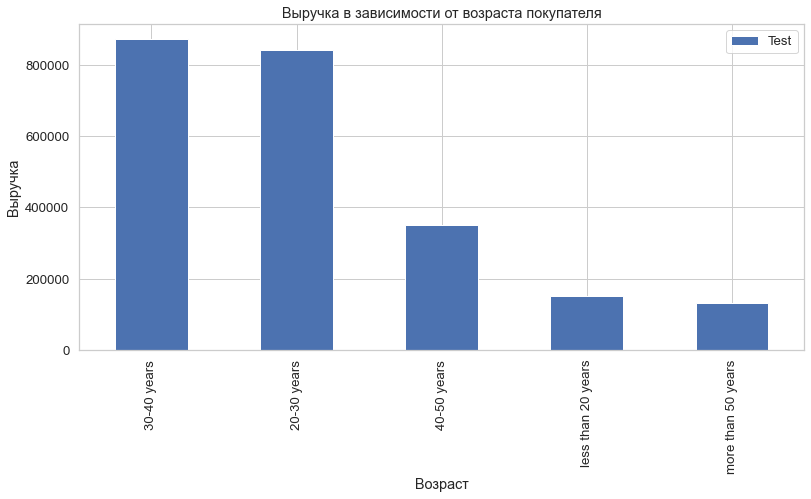

In [256]:
test.groupby('age_groups').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['Test'])
plt.title('Выручка в зависимости от возраста покупателя')
plt.xlabel('Возраст')
plt.ylabel('Выручка');

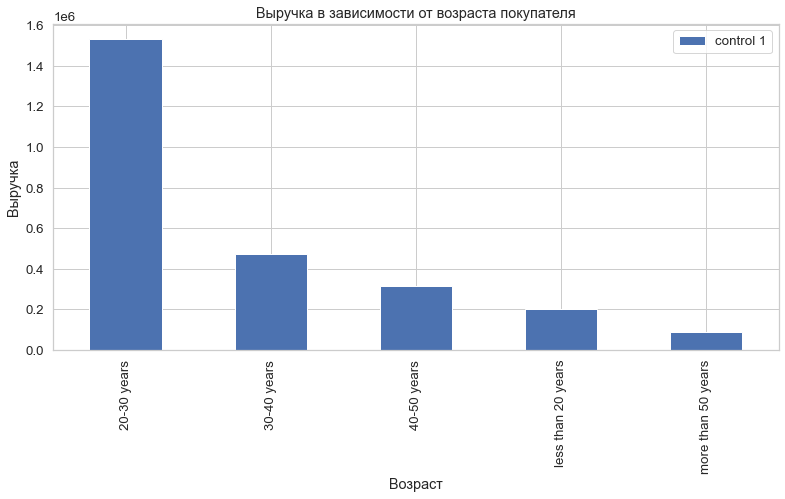

In [257]:
control_1.groupby('age_groups').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['control 1'])
plt.title('Выручка в зависимости от возраста покупателя')
plt.xlabel('Возраст')
plt.ylabel('Выручка');

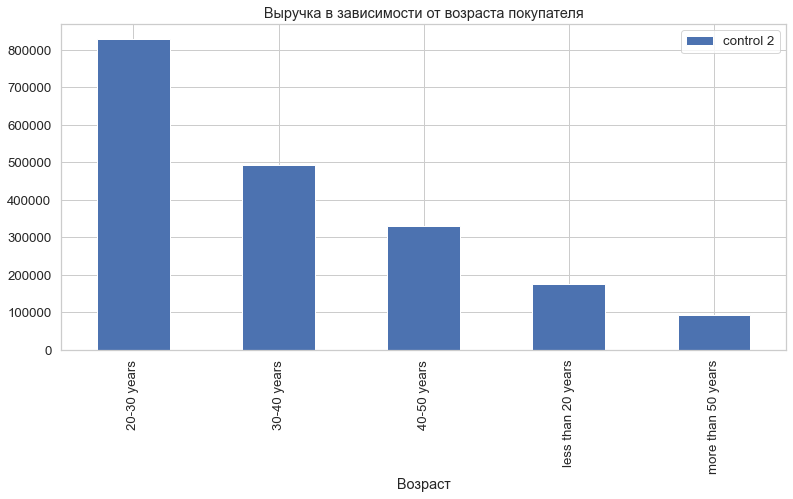

In [258]:
control_2.groupby('age_groups').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).plot.bar()
plt.legend(['control 2'])
plt.title('Выручка в зависимости от возраста покупателя')
plt.xlabel('Возраст');

In [259]:
# Конверсия и ARPPU в тестовой группе.
test_age = test.groupby('age_groups', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head(3)
test_age = test_age.merge(users_test.groupby('age_groups', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='age_groups')
test_age['conversion'] = round(test_age.uid/test_age.users*100, 2)
test_age['ARPPU'] = round(test_age.revenue/test_age.uid)
test_age.sort_values(by=['conversion', 'ARPPU'], ascending=False).rename(columns={'uid':'customers'})

,age_groups,customers,revenue,users,conversion,ARPPU
0,30-40 years,57,871351,1195,4.77,15287.0
2,40-50 years,19,349414,608,3.12,18390.0
1,20-30 years,50,840697,1874,2.67,16814.0


In [260]:
# Конверсия и ARPPU в певрвой контрольной группе.
control_1_age = control_1.groupby('age_groups', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head(3)
control_1_age = control_1_age.merge(users_control_1.groupby('age_groups', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='age_groups')
control_1_age['conversion'] = round(control_1_age.uid/control_1_age.users*100, 2)
control_1_age['ARPPU'] = round(control_1_age.revenue/control_1_age.uid)
control_1_age.sort_values(by=['conversion', 'ARPPU'], ascending=False).rename(columns={'uid':'customers'})

,age_groups,customers,revenue,users,conversion,ARPPU
0,20-30 years,95,1530880.0,1853,5.13,16115.0
2,40-50 years,26,315692.0,652,3.99,12142.0
1,30-40 years,44,474643.0,1225,3.59,10787.0


In [261]:
# Конверсия и ARPPU во второй контрольной группе.
control_2_age = control_2.groupby('age_groups', as_index=False).agg({'uid': 'nunique', 'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head(3)
control_2_age = control_2_age.merge(users_control_2.groupby('age_groups', as_index=False).agg({'uid': 'nunique'}).rename(columns={'uid': 'users'}), on='age_groups')
control_2_age['conversion'] = round(control_2_age.uid/control_2_age.users*100, 2)
control_2_age['ARPPU'] = round(control_2_age.revenue/control_2_age.uid)
control_2_age.sort_values(by=['conversion', 'ARPPU'], ascending=False).rename(columns={'uid':'customers'})

,age_groups,customers,revenue,users,conversion,ARPPU
2,40-50 years,30,331487,615,4.88,11050.0
0,20-30 years,84,828464,1835,4.58,9863.0
1,30-40 years,45,492219,1192,3.78,10938.0


В тестовой группе число покупателей выросло в возрастной группе 30-40 лет (до 57 человек, в первой контрольной группе 44 человека, во второй контрольной группе 45), что привело к росту выручки для этой группы на 45,5% для первой  и на 43,5% для второй контрольных групп. В свою очередь конверсия для этой возрастной группы увеличилась на 1,18% по сравнению с первой и на 0,99% по сравнению со второй контрольными группами.


### Выводы по разделу: 
Нововведение привело к увеличению числа покупателей, росту выручки, дохода с покупателя и конверсии для пользователей из Испании, а также для возрастной группы 30-40 лет. С осторожностью можно говорить, что нововведение менее привлекательно для пользователей 0 пола.

## Выводы по проекту:

1. Эксперимент нельзя назвать полностью удачным. Несмотря на рост выручки и среднего чека от премиум-подписок, наблюдается тенденция, что пользователи предпочитают покупать сначала  более дешевую пробную подписку, так как выручка и средний чек, от ее продажи также увеличился в тестовой группе по отношению к обеим контрольным группам. Эксперимент привел к снижению числа покупателей и конверсии, но не повлиял на удержание (Retention). Таким образом, если провести более детальные исследование, выявить причины уменьшения конверсия и разработать меры по ее увеличению, то идея изменения стоимости подписки может иметь смысл.
2. Группы в которых эксперимент приве одновременно к росту и выручки и конверсии, это пользователи из Испании, а также пользователи из возрастной группы 30-40 лет.